# ### TODO: Outline image here###

# Table of contents

1. [Libraries & Environment](#Libraries-&-Environment)
1. [Data Preprocessing](#Data-Preprocessing)
    1. Tiling
    1. Filtering out background tiles
    1. Macenko normalization
    1. Tumor detection
1. [Training Deep Learning Models](#Training-Deep-Learning-Models)
    1. Data splitting
    1. Model and data loading
    1. Main training loop
    1. Miscellaneous
1. [Evaluating & Visualizing Performance](#Evaluating-&-Visualizing-Performance)
    1. Patient-level vs. tile-level evaluation
    1. Visualizing performance over time
    1. On improving performance
1. [Bonus: XML annotations](#XML-annotations)

# Libraries & Environment

The base environment that I use can be installed using the create_conda_env.sh bash script.

NB: As of June 2021, when installing OpenSlide on Linux, it will not work correctly with some image types due to a broken dependency. (I've noticed this problem for .mrxs images in particular) In order to repair this issue, you can install version 0.40.0 of the pixman library. (Installed automatically in the create_conda_env.sh script) If you notice the slide images look like like the image below, or throw an error when you view them, try this solution.

TODO: insert image

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from openslide import OpenSlide, OpenSlideError
import pandas as pd
from pathlib import Path
from PIL import Image
import re
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shutil
import time
import tqdm
import traceback
import warnings
%matplotlib inline

# Pytorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, models, transforms

# Custom imports
from library.eval_utils import find_optimal_threshold
from library.MacenkoNormalizer import MacenkoNormalizer
from library.model_utils import load_saved_model_for_inference, load_model_arch

# DEVICE determines which GPU (or CPU) the deep learning code will be run on
# DEVICE = torch.device('cpu')
DEVICE = torch.device('cuda:0')

# Data Preprocessing

In order to prepare the WSI images for deep learning training and inference, a number of preprocessing steps must be applied:

1. Images are broken into many small tiles (usually 256x256 microns)
1. Tiles are filtered to exclude non-tissue background regions
1. Tiles are Macenko-normalized
1. Tiles are filtered to exclude non-tumorous tissue regions

These steps are laid out in example code below. However, when applying this pipeline at scale, the implementation should include multiprocessing and/or CuPy (for Macenko normalization) as these additions provide enormous speedups.

In [2]:
# MICRONS_PER_TILE defines the tile edge length used when breaking WSIs into smaller images
MICRONS_PER_TILE = 256.

# Initialize the Macenko Normalizer
reference_img = np.array(Image.open('library/macenko_reference_img.png').convert('RGB'))
normalizer = MacenkoNormalizer()
normalizer.fit(reference_img)

# Find all WSIs and check for errors opening the file or finding the microns-per-pixel values 
base_path = Path('WSIs')
base_save_path = Path('tiled_WSIs')
wsi_paths = base_path.rglob('*.svs')
save_paths = []
wsi_paths_to_normalize = []
total_num_tiles = 0
for wsi_path in wsi_paths:
    try:
        with OpenSlide(str(wsi_path)) as wsi:
            sub_path = Path(str(wsi_path)[len(str(base_path)) + 1:-len(wsi_path.suffix)])
            save_path = base_save_path / sub_path

            if (save_path / 'Finished.txt').exists():
                print('Ignoring {}, as it has already been processed.'.format(wsi_path))
            else:
                pixels_per_tile_x = int(MICRONS_PER_TILE / float(wsi.properties['openslide.mpp-x']))
                pixels_per_tile_y = int(MICRONS_PER_TILE / float(wsi.properties['openslide.mpp-y']))
                wsi_paths_to_normalize.append(wsi_path)
                save_paths.append(save_path)
                save_path.mkdir(parents=True, exist_ok=True)
                total_num_tiles += (
                        len(range(pixels_per_tile_x, wsi.dimensions[0] - pixels_per_tile_x, pixels_per_tile_x)) *
                        len(range(pixels_per_tile_y, wsi.dimensions[1] - pixels_per_tile_y, pixels_per_tile_y)))
    except OpenSlideError:
        print('Ignoring {}, as it cannot be opened by OpenSlide.'.format(wsi_path))
    except KeyError:
        print('Ignoring {}, as it does not have a defined microns-per-pixel value'.format(wsi_path))

print(f'Masking and normalizing {total_num_tiles} tiles from {len(wsi_paths_to_normalize)} whole slide images.')

Ignoring WSIs/MSS/TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B.svs, as it has already been processed.
Ignoring WSIs/MSS/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs, as it has already been processed.
Ignoring WSIs/MSI-H/TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7.svs, as it has already been processed.
Ignoring WSIs/MSI-H/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014.svs, as it has already been processed.
Masking and normalizing 0 tiles from 0 whole slide images.


This function, given a whole slide image path and target save path, masks and normalizes all tissue tiles and then saves them into pngs.

In [3]:
def mask_and_normalize_wsi(wsi_path, save_path, pbar):
    num_tiles_kept = 0
    try:
        with OpenSlide(str(wsi_path)) as wsi:
            pptx = int(MICRONS_PER_TILE / float(wsi.properties['openslide.mpp-x']))
            ppty = int(MICRONS_PER_TILE / float(wsi.properties['openslide.mpp-y']))
            # Leave out border of image
            for x in range(pptx, wsi.dimensions[0] - pptx, pptx):
                for y in range(ppty, wsi.dimensions[1] - ppty, ppty):
                    tile = wsi.read_region((x, y), level=0, size=(pptx, ppty)).convert('RGB')
                    # Mask away all-white and all-black background regions
                    mask = tile.convert(mode='L').point(lut=lambda p: 220 > p > 10, mode='1')
                    mask = ndimage.binary_fill_holes(mask)
                    if np.sum(mask).astype(float) / mask.size > 0.5:
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore')
                            try:
                                # Normalize the tile
                                tile = normalizer.transform(np.array(tile))
                                tile = Image.fromarray(tile)
                                # Resize the image to 224x224
                                tile = tile.resize((224, 224), Image.LANCZOS)
                                num_tiles_kept += 1
                                filename = f'{wsi_path.stem}__x{x}_y{y}_dx{pptx}_dy{ppty}.png'
                                tile.save(save_path / filename, format='PNG')
                            except np.linalg.LinAlgError:
                                pass
                    pbar.update()
    except OpenSlideError as ex:
        print('\nUnable to process {}:'.format(wsi_path))
        print(''.join(traceback.format_exception(etype=type(ex), value=ex, tb=ex.__traceback__)))
        shutil.rmtree(save_path)
        return 0

    with open(save_path / 'Finished.txt', 'w+') as file:
        file.write('Kept and processed {} tiles.'.format(num_tiles_kept))
    return num_tiles_kept

### Tiling, background filtering, and Macenko normalization

In [4]:
assert len(wsi_paths_to_normalize) == len(save_paths)
with tqdm.tqdm(total=total_num_tiles) as pbar:
    for wsi_path, save_path in zip(wsi_paths_to_normalize, save_paths):
        mask_and_normalize_wsi(wsi_path, save_path, pbar)
# Wait a moment for pbar to close
time.sleep(0.25)

all_save_paths = [p for p in base_save_path.glob('*/*') if p.is_dir()]
total_tiles_kept = 0
for save_path in all_save_paths:
    with open(save_path / 'Finished.txt', 'r') as f:
        info = f.readline()
    num_tiles_kept = int(re.search('processed ([0-9]+?) tiles', info).group(1))
    total_tiles_kept += num_tiles_kept
    print(f'{num_tiles_kept} tiles from patient {save_path.stem} saved to {save_path}')
print(f'{total_tiles_kept} tiles were saved and normalized')

0it [00:00, ?it/s]


2051 tiles from patient TCGA-4N-A93T-01Z-00-DX1 saved to tiled_WSIs/MSS/TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B
2960 tiles from patient TCGA-3L-AA1B-01Z-00-DX1 saved to tiled_WSIs/MSS/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F
4172 tiles from patient TCGA-5M-AAT6-01Z-00-DX1 saved to tiled_WSIs/MSI-H/TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014
6951 tiles from patient TCGA-5M-AATE-01Z-00-DX1 saved to tiled_WSIs/MSI-H/TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7
16134 tiles were saved and normalized


### Tumor detection

Now that WSIs have been broken into normalized tiles, we load these images for tumor detection.

NB: Make sure to use `with torch.no_grad():` at inference time.

In [5]:
print('Loading images for tumor detection...')
img_dataset = datasets.ImageFolder(
    base_save_path,
    transforms.Compose([
        # Images must be of size 224x224 to be passed to most deep learning vision models
        transforms.Resize(224),
        transforms.ToTensor()
    ])
)
img_dataloader = data.DataLoader(
    img_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    pin_memory=True
)
tumor_detection_model = load_saved_model_for_inference(
    'saved_models/resnet18_tumor_detection_exp9.pt',
    num_classes=2,
).to(DEVICE)

print(f'Getting tumor predictions for {len(img_dataset)} tiles in {len(img_dataloader)} batches.')
time.sleep(0.25)
all_preds = []

with torch.no_grad():
    for inputs, _ in tqdm.tqdm(img_dataloader):
        inputs = inputs.to(DEVICE, non_blocking=True)
        outputs = tumor_detection_model(inputs).cpu()
        all_preds.append(outputs)
all_preds = torch.cat(all_preds, dim=0)
time.sleep(0.25)

tumorous_tiles = all_preds.argmax(dim=1).flatten()
print(f'{tumorous_tiles.sum()}/{len(img_dataset)} tiles contain tumorous tissue')

Loading images for tumor detection...
Getting tumor predictions for 16134 tiles in 127 batches.


100%|██████████| 127/127 [00:08<00:00, 14.39it/s]


9806/16134 tiles contain tumorous tissue


In [24]:
tile_ids = [Path(s[0]).name for s in img_dataset.samples]
patient_ids = [t.split('__')[0] for t in tile_ids]
msi_status = [Path(s[0]).parents[1].name for s in img_dataset.samples]
tile_info_df = pd.DataFrame({
    'tile_id': tile_ids,
    'patient_id': patient_ids,
    'tumor_pred_val': all_preds[:, 1].numpy(),
    'tumor_pred_class': tumorous_tiles.numpy(),
    'MSI_status': msi_status,
})
tile_info_df.set_index('tile_id', inplace=True)
tile_df_save_path = base_save_path / 'tile_info.csv'
tile_info_df.to_csv(tile_df_save_path)
print(f'Saved tile_info_df to "{tile_df_save_path}"')

patient_info_df = pd.DataFrame({
    'patient_id': tile_info_df['patient_id'].unique(),
    'MSI_status': '',
})
patient_info_df.set_index('patient_id', inplace=True)
for patient_id, msi_status in tile_info_df.groupby('patient_id').MSI_status.unique().iteritems():
    # Make sure that MSI status is the same for all tiles within a patient
    msi_status, = msi_status
    patient_info_df.loc[patient_id] = msi_status
patient_df_save_path = base_save_path / 'patient_info.csv'
patient_info_df.to_csv(patient_df_save_path)
print(f'Saved patient_info_df to "{patient_df_save_path}"')

display(patient_info_df.style.set_caption('Patient info dataframe'))
tile_info_df.groupby('patient_id').head(2).style.set_caption('Tile info dataframe, example rows')

Saved tile_info_df to "tiled_WSIs/tile_info.csv"
Saved patient_info_df to "tiled_WSIs/patient_info.csv"


,MSI_status
patient_id,
TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014,MSI-H
TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7,MSI-H
TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F,MSS
TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B,MSS


,patient_id,tumor_pred_val,tumor_pred_class,MSI_status
tile_id,,,,
TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014__x100287_y12156_dx1013_dy1013.png,TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014,0.010808,0,MSI-H
TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014__x100287_y13169_dx1013_dy1013.png,TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014,0.045893,0,MSI-H
TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7__x100287_y10130_dx1013_dy1013.png,TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7,0.999991,1,MSI-H
TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7__x100287_y11143_dx1013_dy1013.png,TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7,0.999997,1,MSI-H
TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F__x10130_y33429_dx1013_dy1013.png,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F,1.000000,1,MSS
TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F__x10130_y34442_dx1013_dy1013.png,TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F,1.000000,1,MSS
TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B__x10130_y31403_dx1013_dy1013.png,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B,0.010911,0,MSS
TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B__x10130_y32416_dx1013_dy1013.png,TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B,0.668856,1,MSS


# Training Deep Learning Models

The deep learning model pipeline consists of three main steps:
1. Data splitting
1. Model and data loading
1. Training loop
    1. Performing inference
    1. Calculating loss
    1. Backpropagating loss
    1. Updating parameters
    1. Logging results

This notebook will also cover a few other important things to consider:
1. Common hardware bottlenecks
1. Real-time performance monitoring
1. Misc.

### Data splitting

First, we split the patients into a train/validation set and a test set.

Normally, 10-20% of patients would be assigned to the test set, but since we only have 4 patients in our example dataset, we will perform a 50/50 split.

In [7]:
train_val_set, test_set = train_test_split(
    patient_info_df.index.values,
    test_size=0.5,
    stratify=patient_info_df['MSI_status'].values
)
patient_info_df.loc[train_val_set, 'data_subset'] = 'train/validation'
patient_info_df.loc[test_set, 'data_subset'] = 'test'
tile_info_df = tile_info_df.drop(
    columns='data_subset',
    errors='ignore'
).join(
    patient_info_df['data_subset'],
    on='patient_id'
)

Then, we split the tiles from the train/validation patients into a train set and a validation set.

In [8]:
train_val_mask = tile_info_df['data_subset'] != 'test'
train_set, val_set = train_test_split(
    tile_info_df.index.values[train_val_mask],
    train_size=0.9,
    stratify=tile_info_df['patient_id'].values[train_val_mask]
)
tile_info_df.loc[train_set, 'data_subset'] = 'train'
tile_info_df.loc[val_set, 'data_subset'] = 'validation'

tile_info_df.to_csv(tile_df_save_path)
print(f'Saved updated tile_info_df to "{tile_df_save_path}"')
patient_info_df.to_csv(patient_df_save_path)
print(f'Saved updated patient_info_df to "{patient_df_save_path}"')

Saved updated tile_info_df to "tiled_WSIs/tile_info.csv"
Saved updated patient_info_df to "tiled_WSIs/patient_info.csv"


Verify that there are no patients with tiles in both the train and test set.

In [9]:
tile_info_df.groupby('patient_id')['data_subset'].unique()

patient_id
TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F    [train, validation]
TCGA-4N-A93T-01Z-00-DX1.82E240B1-22C3-46E3-891F-0DCE35C43F8B                 [test]
TCGA-5M-AAT6-01Z-00-DX1.8834C952-14E3-4491-8156-52FC917BB014    [train, validation]
TCGA-5M-AATE-01Z-00-DX1.483FFD2F-61A1-477E-8F94-157383803FC7                 [test]
Name: data_subset, dtype: object

### Model and data loading

Here we load the data and model and move the model to the correct device.

In order to split the train and test sets, and only include tumor images, we define a function to check that a given image path is tumorous and in the correct data subset.

The model architectures I've tried and had the most success with are, in no particular order:
1. densenet201
1. resnet18
1. shufflenet_v2_x1_0
1. squeezenet1_1

However, this is a decision that depends on the amount of data and compute available. For a list of all ImageNet pretrained models available through PyTorch, see https://pytorch.org/vision/stable/models.html.

Here we'll use SqueezeNet since it is the smallest and fastest.

The choice of optimizer and learning rate is another important hyperparameter choice. For this example we'll use Adam. An excellent overview of various optimizers can be found here: https://ruder.io/optimizing-gradient-descent/

We also define class importance weights based on the inverse of the number of samples in each class.

In [10]:
# This function defines which files will be allowed in the dataset. Using it, we can subset data without physically moving images into separate folders
def get_subset_func(data_subset):
    def is_valid_img(path):
        if not Path(path).suffix == '.png':
            return False
        row = tile_info_df.loc[Path(path).name]
        return row['tumor_pred_class'] == 1 and row['data_subset'] == data_subset
    return is_valid_img

# We perform a number of random operations to the images in order to augment the training data
# For validation and test data, these transforms are not necessary, but Resize(224) and ToTensor() still are
PHASES = ['train', 'validation', 'test']
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(180, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ]),
}

# Load the images
BATCH_SIZE = 32
print('Loading images for training...')
img_datasets = {
    phase: datasets.ImageFolder(
        base_save_path,
        transform=data_transforms[phase],
        is_valid_file=get_subset_func(phase)
    ) for phase in PHASES
}
img_dataloaders = {
    phase: data.DataLoader(
        img_datasets[phase],
        batch_size=BATCH_SIZE,
        num_workers=8,
        shuffle=(phase == 'train'),
        pin_memory=True
    ) for phase in PHASES
}
num_classes = len(img_datasets['train'].classes)
for phase in PHASES:
    print(f'Loaded {len(img_datasets[phase])} {phase} images.')

# Load the model
MODEL_ARCHITECTURE = models.squeezenet1_1
model = load_model_arch(MODEL_ARCHITECTURE, pretrained=True, num_classes=2).to(DEVICE)
n_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Loaded model "{MODEL_ARCHITECTURE.__name__}" with {n_train_params:,d} trainable parameters.')

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Get class importance weights
class_samples = []
class_weights = []
for i, c in enumerate(img_datasets['train'].classes):
    n_samples = np.sum(np.array(img_datasets['train'].targets) == i)
    if n_samples == 0:
        raise RuntimeError(f'Class "{c}" has no samples. Make sure there are no empty folders in the image dataset folder.')
    class_samples.append(n_samples)
    class_weights.append(1. / n_samples)
class_weights = torch.tensor(class_weights).float()
class_weights = class_weights / class_weights.sum()
for i, w in enumerate(class_weights.tolist()):
    print(f'Class "{img_datasets["train"].classes[i]}" with {class_samples[i]} samples was given a weight of {w:.2f}.')

loss_func = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))

Loading images for training...
Loaded 3382 train images.
Loaded 327 validation images.
Loaded 6097 test images.
Loaded model "squeezenet1_1" with 723,522 trainable parameters.
Class "MSI-H" with 2139 samples was given a weight of 0.37.
Class "MSS" with 1243 samples was given a weight of 0.63.


### Main training loop

In [26]:
# Weights are stored for model checkpointing
best_model_weights = copy.deepcopy(model.state_dict())
validation_losses = []
stop = False
dataset_sizes = {p: len(img_datasets[p]) for p in PHASES}

# Log various stats for visualization after training
log_dict = {}
for phase in PHASES:
    log_dict[phase + '_acc'] = []
    log_dict[phase + '_loss'] = []
    log_dict[phase + '_roc_auc'] = []

MAX_N_EPOCHS = 100
for epoch in range(MAX_N_EPOCHS):
    # Cycle through training and validation, only testing the model once all training and validation has finished
    for phase in PHASES:
        if phase == 'train':
            model.train()
        elif phase == 'validation':
            model.eval()
        else:
            # Only test after all training and validation has finished
            if epoch == MAX_N_EPOCHS - 1 or stop:
                print('\n' + '#' * 10 + ' Beginning tile-level testing ' + '#' * 10)
                # Reload the best model checkpoint
                model.load_state_dict(best_model_weights)
                model.eval()
            else:
                log_dict[phase + '_acc'].append(None)
                log_dict[phase + '_loss'].append(None)
                log_dict[phase + '_roc_auc'].append(None)
                continue
        y_true = np.empty((0, num_classes))
        y_score = np.empty((0, num_classes))
        
        running_loss = 0.
        running_corrects = 0
        for i, (inputs, labels) in tqdm.tqdm(enumerate(img_dataloaders[phase]),
                                             desc=f'Epoch {epoch}/{MAX_N_EPOCHS}, {phase:>10}',
                                             total=len(img_dataloaders[phase])):
            # Move the data to the GPU
            inputs = inputs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass, only enabling gradient computation during training
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, dim=1)
                loss = loss_func(outputs, labels)
                # Backward pass and update weights only during training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                y_true = np.concatenate([y_true, np.eye(num_classes)[labels.detach().cpu().numpy().ravel()]])
                y_score = np.concatenate([y_score, F.softmax(outputs.detach(), dim=1).cpu().numpy()])
                    
            # Track stats for logging
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            current_loss = running_loss / (i + 1) / BATCH_SIZE
        
        time.sleep(0.25)
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float().cpu().numpy() / dataset_sizes[phase]
        epoch_roc_auc = roc_auc_score(y_true, y_score)
        print(f'Epoch {epoch}/{MAX_N_EPOCHS}, {phase:>10}: Loss {epoch_loss:.2f}\tAcc: {epoch_acc:.2f}\tAUROC: {epoch_roc_auc:.2f}')
        
        log_dict[phase + '_loss'].append(epoch_loss)
        log_dict[phase + '_acc'].append(epoch_acc)
        log_dict[phase + '_roc_auc'].append(epoch_roc_auc)
        
        if phase == 'validation':
            # Save model checkpoint if validation reaches a new minimum
            if len(validation_losses) == 0 or epoch_loss < min(validation_losses):
                best_model_weights = copy.deepcopy(model.state_dict())
            validation_losses.append(epoch_loss)
            # Stop training if validation performance does not improve for N epochs
            N = 5
            if np.argmin(validation_losses) < len(validation_losses) - N:
                stop = True
    if stop:
        break
log_df = pd.DataFrame(log_dict)
log_df.index.rename('Epoch', inplace=True)

Epoch 0/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.42it/s]


Epoch 0/100,      train: Loss 0.06	Acc: 0.98	AUROC: 1.00


Epoch 0/100, validation: 100%|██████████| 11/11 [00:00<00:00, 36.11it/s]


Epoch 0/100, validation: Loss 0.02	Acc: 1.00	AUROC: 1.00


Epoch 1/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.96it/s]


Epoch 1/100,      train: Loss 0.07	Acc: 0.97	AUROC: 1.00


Epoch 1/100, validation: 100%|██████████| 11/11 [00:00<00:00, 35.99it/s]


Epoch 1/100, validation: Loss 0.12	Acc: 0.97	AUROC: 1.00


Epoch 2/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.73it/s]


Epoch 2/100,      train: Loss 0.13	Acc: 0.95	AUROC: 0.99


Epoch 2/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.42it/s]


Epoch 2/100, validation: Loss 0.56	Acc: 0.72	AUROC: 1.00


Epoch 3/100,      train: 100%|██████████| 106/106 [00:03<00:00, 27.94it/s]


Epoch 3/100,      train: Loss 0.06	Acc: 0.98	AUROC: 1.00


Epoch 3/100, validation: 100%|██████████| 11/11 [00:00<00:00, 35.95it/s]


Epoch 3/100, validation: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 4/100,      train: 100%|██████████| 106/106 [00:03<00:00, 27.79it/s]


Epoch 4/100,      train: Loss 0.07	Acc: 0.98	AUROC: 1.00


Epoch 4/100, validation: 100%|██████████| 11/11 [00:00<00:00, 33.36it/s]


Epoch 4/100, validation: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 5/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.25it/s]


Epoch 5/100,      train: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 5/100, validation: 100%|██████████| 11/11 [00:00<00:00, 35.30it/s]


Epoch 5/100, validation: Loss 0.01	Acc: 0.99	AUROC: 1.00


Epoch 6/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.51it/s]


Epoch 6/100,      train: Loss 0.04	Acc: 0.98	AUROC: 1.00


Epoch 6/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.20it/s]


Epoch 6/100, validation: Loss 0.05	Acc: 0.98	AUROC: 1.00


Epoch 7/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.10it/s]


Epoch 7/100,      train: Loss 0.04	Acc: 0.99	AUROC: 1.00


Epoch 7/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.36it/s]


Epoch 7/100, validation: Loss 0.04	Acc: 0.98	AUROC: 1.00


Epoch 8/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.23it/s]


Epoch 8/100,      train: Loss 0.06	Acc: 0.98	AUROC: 1.00


Epoch 8/100, validation: 100%|██████████| 11/11 [00:00<00:00, 36.63it/s]


Epoch 8/100, validation: Loss 0.08	Acc: 0.98	AUROC: 1.00


Epoch 9/100,      train: 100%|██████████| 106/106 [00:03<00:00, 27.69it/s]


Epoch 9/100,      train: Loss 0.05	Acc: 0.98	AUROC: 1.00


Epoch 9/100, validation: 100%|██████████| 11/11 [00:00<00:00, 33.93it/s]


Epoch 9/100, validation: Loss 0.06	Acc: 0.98	AUROC: 1.00


Epoch 10/100,      train: 100%|██████████| 106/106 [00:03<00:00, 30.02it/s]


Epoch 10/100,      train: Loss 0.04	Acc: 0.99	AUROC: 1.00


Epoch 10/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.99it/s]


Epoch 10/100, validation: Loss 0.01	Acc: 0.99	AUROC: 1.00


Epoch 11/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.95it/s]


Epoch 11/100,      train: Loss 0.04	Acc: 0.98	AUROC: 1.00


Epoch 11/100, validation: 100%|██████████| 11/11 [00:00<00:00, 37.07it/s]


Epoch 11/100, validation: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 12/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.18it/s]


Epoch 12/100,      train: Loss 0.07	Acc: 0.98	AUROC: 1.00


Epoch 12/100, validation: 100%|██████████| 11/11 [00:00<00:00, 36.25it/s]


Epoch 12/100, validation: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 13/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.88it/s]


Epoch 13/100,      train: Loss 0.05	Acc: 0.98	AUROC: 1.00


Epoch 13/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.83it/s]


Epoch 13/100, validation: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 14/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.32it/s]


Epoch 14/100,      train: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 14/100, validation: 100%|██████████| 11/11 [00:00<00:00, 36.38it/s]


Epoch 14/100, validation: Loss 0.01	Acc: 1.00	AUROC: 1.00


Epoch 15/100,      train: 100%|██████████| 106/106 [00:03<00:00, 29.24it/s]


Epoch 15/100,      train: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 15/100, validation: 100%|██████████| 11/11 [00:00<00:00, 35.97it/s]


Epoch 15/100, validation: Loss 0.01	Acc: 0.99	AUROC: 1.00


Epoch 16/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.61it/s]


Epoch 16/100,      train: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 16/100, validation: 100%|██████████| 11/11 [00:00<00:00, 37.67it/s]


Epoch 16/100, validation: Loss 0.02	Acc: 0.99	AUROC: 1.00


Epoch 17/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.49it/s]


Epoch 17/100,      train: Loss 0.05	Acc: 0.98	AUROC: 1.00


Epoch 17/100, validation: 100%|██████████| 11/11 [00:00<00:00, 33.59it/s]


Epoch 17/100, validation: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 18/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.88it/s]


Epoch 18/100,      train: Loss 0.04	Acc: 0.98	AUROC: 1.00


Epoch 18/100, validation: 100%|██████████| 11/11 [00:00<00:00, 38.78it/s]


Epoch 18/100, validation: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 19/100,      train: 100%|██████████| 106/106 [00:03<00:00, 28.70it/s]


Epoch 19/100,      train: Loss 0.03	Acc: 0.99	AUROC: 1.00


Epoch 19/100, validation: 100%|██████████| 11/11 [00:00<00:00, 34.85it/s]


Epoch 19/100, validation: Loss 0.01	Acc: 0.99	AUROC: 1.00

########## Beginning tile-level testing ##########


Epoch 19/100,       test: 100%|██████████| 191/191 [00:02<00:00, 83.97it/s]


Epoch 19/100,       test: Loss 1.49	Acc: 0.45	AUROC: 0.95


### Miscellaneous notes

1. In order to change which GPU the code is run on to GPU N, simply change the `DEVICE` parameter to `torch.device('cuda:N')` when calling `data.to(DEVICE)` or `model.to(DEVICE)`. Alternatively on linux, one can leave the device as `torch.device('cuda:0')` and call `CUDA_VISIBLE_DEVICES=N python my_script.py` when running a python script.


2. When training deep neural networks, keep an eye on the GPU usage with the `nvidia-smi` command. If the GPU usage is below 90% during the "train" phase of code, then that means that the GPU is idling/waiting for data and there is a bottleneck in the pipeline. In order to remove such bottlenecks, I recommend:
    1. Use Linux, not Windows - PyTorch dataloaders are slower in Windows. (I've never tried Mac, but I imagine it would work similarly to Linux)
    1. Make sure to keep the tiled image data on a local SSD (or at least a local HDD) for the best throughput. Reading data from a network drive will greatly slow down training.
    1. Increase the `num_workers` pytorch dataloader parameter, but not to more workers than the CPU has cores.
    1. Increase the batch size. One of the main bottlenecks in running CUDA code on a GPU is the CPU-GPU transfer time. Transferring and operating on data in larger chunks better utilizes the built-in GPU parallelization capacity.
    1. Check to see if other processes/users are using the CPU. (`htop` is a handy tool for this)
    1. Check that the RAM is not fully utilized. This should rarely be a problem on your PC, but when it is a problem on a server from over-usage, it dramatically slows everything down.
    1. Use the `taskset` command when running multiple experiments to help ensure you do not overload the available CPU cores.


3. On the other hand, sometimes you will find that the GPU is being fully utilized and is itself the bottleneck. In these cases, you can do the following to speed up training:
    1. Use mixed precision training. This will only work on GPUs with tensor cores, but does offer a significant speedup and is very easy to implement. See: https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
    1. Use multi-GPU parallelization. https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html


4. In this example notebook we log all performance statistics as text output. This can become inconvenient if you are running jobs remotely and/or running multiple jobs at once. I recommend using pytorch's tensorboard integration if you would like to monitor performance live: https://pytorch.org/docs/stable/tensorboard.html


5. Whenever you are trying new models or pipelines, it is generally a good idea to perform a trial run with toy data. If the model does not converge on otherwise trivial data, then you know right away that something is wrong and don't have to wait for the results from a full run.


6. On a related note, sometimes you'll encounter NaN gradients during training due to gradient explosion. If that happens consistently, you can try:
    1. Reduce the learning rate
    1. Make sure there is not something wrong with the model architecture if you are using a custom architecture, and make sure that you do not have softmax as the final layer when using nn.CrossEntropyLoss.
    1. Use nn.CrossEntropyLoss instead of taking the log of a softmax layer with NLL loss. Pytorch's cross entropy loss uses the log-sum-exp trick to combine the log-softmax and NLL loss operations to improve numerical stability.

# Evaluating & Visualizing Performance

So far, we've trained the models and evaluated performance at a tile level. Ultimately however, the goal is to make decisions at a patient level. To convert a tile-level prediction to a patient-level one, we simply take the mean tile-level prediction. This is not the only way, nor necessarily the best way, to make a patient-level prediction, and could probably use improvement. (Multi-instance learning, for example, is another way to go about things)

Here is a function to get the patient-level performance:

In [27]:
def get_patient_id(path):
    img_name = Path(path).name
    return img_name.split('__')[0]


# This decorator stops the function from automatically using pytorch autograd
@torch.no_grad()
def get_patient_level_results(model, img_dataloader, threshold=None):
    img_dataset = img_dataloader.dataset
    num_classes = len(img_dataset.classes)
    patient_ids = np.array([get_patient_id(path) for path, _ in img_dataset.samples])
    patient_ids = np.unique(patient_ids)
    patient_idxs = []
    patient_classes_dict = {}
    # Ensure there are no patients who have image tiles with different class labels
    for path, class_idx in img_dataset.samples:
        patient_id = get_patient_id(path)
        patient_idxs.append(np.arange(len(patient_ids))[patient_ids == patient_id])
        if patient_id in patient_classes_dict.keys():
            if patient_classes_dict[patient_id][0] != class_idx:
                raise RuntimeError('Patients must have a single class per patient. ' +
                                   '{} was classified as {} and {} in images {} and {}.'.format(
                                       patient_id,
                                       patient_classes_dict[patient_id][0],
                                       class_idx,
                                       patient_classes_dict[patient_id][1],
                                       path
                                   ))
        else:
            patient_classes_dict[patient_id] = (class_idx, path)
    patient_idxs = np.array(patient_idxs).ravel()
    patient_classes = [patient_classes_dict[pid][0] for pid in patient_ids]
    
    all_preds = torch.empty((0, num_classes)).to(DEVICE)
    for inputs, _ in tqdm.tqdm(img_dataloader, desc='Patient-level testing'):
        inputs = inputs.to(DEVICE)
        preds = model(inputs)
        preds = F.softmax(preds, dim=-1)
        all_preds = torch.cat([all_preds, preds], dim=0)
    
    all_preds = all_preds.cpu().numpy()
    patient_scores = []
    for i in range(len(patient_ids)):
        patient_scores.append(all_preds[patient_idxs == i].mean(axis=0))
    patient_scores = np.array(patient_scores)
    # Should sum to 1 already, but re-normalize in case of any fp32-induced underflow
    patient_scores = patient_scores / patient_scores.sum(axis=-1, keepdims=True)
    patient_classes_onehot = np.eye(num_classes)[np.array(patient_classes)]
    
    if threshold is None:
        threshold, sensitivity, specificity = find_optimal_threshold(y_true=patient_classes, y_score=patient_scores[:, 1])
        time.sleep(0.25)
        print(f'Calculated optimal threshold of "{threshold:.2f}" using test data class labels.')
    patient_level_roc = roc_auc_score(patient_classes_onehot, patient_scores)
    patient_level_acc = np.mean(np.array(patient_classes) == (patient_scores[:, 1] >= threshold))
    return patient_level_acc, patient_level_roc

It is worth noting that the above function calculates the optimal threshold using the test data if it is not provided a threshold. I've done this for brevity's sake, but ideally one would tune the threshold using the combined training and validation data, not the testing data. (The threshold is used to convert the model's predicted probabilities to binary predictions.) It is worth noting that the AUC will not always equal the accuracy, especially in class-imbalanced situations.

In [28]:
patient_level_acc, patient_level_roc = get_patient_level_results(model, img_dataloaders['test'])
print(f'Patient-level test accuracy: {patient_level_acc:.2f}\tAUROC: {patient_level_roc:.2f}')

Patient-level testing: 100%|██████████| 191/191 [00:02<00:00, 77.42it/s]


Calculated optimal threshold of "0.97" using test data class labels.
Patient-level test accuracy: 1.00	AUROC: 1.00


### Visualizing performance over time

It is also worth visualizing our model's performance over the course of training. We've stored all the metrics in the `log_df` dataframe.

In [29]:
log_df

,train_acc,train_loss,train_roc_auc,validation_acc,validation_loss,validation_roc_auc,test_acc,test_loss,test_roc_auc
Epoch,,,,,,,,,
0,0.977824,0.060320,0.997710,0.996942,0.017966,0.999920,NaN,NaN,NaN
1,0.972206,0.068002,0.997223,0.972477,0.120383,0.999280,NaN,NaN,NaN
2,0.954760,0.129686,0.990807,0.724771,0.556716,0.997081,NaN,NaN,NaN
3,0.978415,0.056467,0.998036,0.993884,0.018470,0.999840,NaN,NaN,NaN
4,0.975458,0.069740,0.996972,0.993884,0.031604,0.999920,NaN,NaN,NaN
5,0.987581,0.028787,0.999482,0.993884,0.013805,0.999800,NaN,NaN,NaN
6,0.984920,0.042584,0.998743,0.975535,0.045114,0.999640,NaN,NaN,NaN
7,0.986103,0.037305,0.999098,0.984709,0.044319,1.000000,NaN,NaN,NaN
8,0.978711,0.061380,0.997447,0.984709,0.076104,0.999560,NaN,NaN,NaN


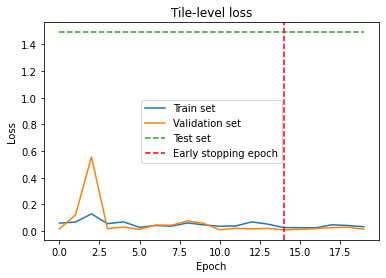

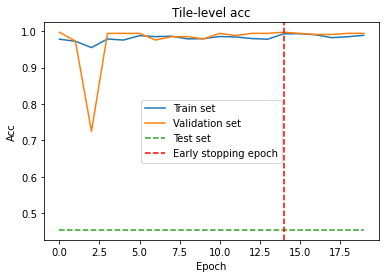

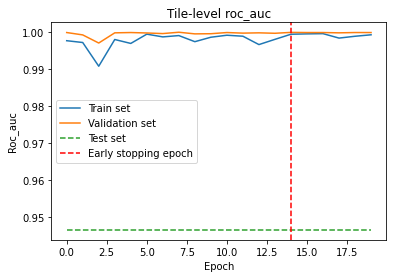

In [36]:
for metric in ['loss', 'acc', 'roc_auc']:
    plt.plot(log_df[f'train_{metric}'].values, label='Train set')
    plt.plot(log_df[f'validation_{metric}'].values, label='Validation set')
    test_vals = log_df[f'test_{metric}'].values
    plt.plot(np.zeros_like(test_vals) + test_vals[-1], label='Test set', linestyle='dashed')
    plt.axvline(np.argmin(log_df[f'validation_loss'].values), label='Early stopping epoch', linestyle='dashed', color='red')
    plt.legend()
    plt.title(f'Tile-level {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.show()

### On improving performance

As expected, the train set performance more or less steadily increased during training, the validation set performance increased at first and then leveled off, and the final test set performance on previously unseen patient data was worse than both training and validation. These trends may be inconsistent or hard to make out on such a small dataset, but tend to hold true as the dataset grows larger. In order to help prevent overfitting, stopped training early when the validation loss stopped improving for a few epochs in a row.

If we want to further improve performance, the best thing to do will be to tune the hyperparameters. These can include:
1. Model architecture
1. Optimizer
1. Learning rate
1. Other optimizer parameters
1. Number of frozen layers (not covered in this notebook)
1. Literally any parameter that can be tuned

Hyperparameter tuning can be done systematically by running many experiments with different combinations of parameters, or by hand using one's intuition. If the model is overfitting too much, one can:
1. Use a smaller model
1. Increase the learning rate
1. Use a larger validation set for early stopping
1. Freeze more layers

Alternatively, if the model is underfitting, one can:
1. Increase the size of the model
1. Decrease the learning rate
1. Increase the amount of train data
1. Freeze fewer layers
1. Train for longer

Finally, if training is taking too long, one might consider:
1. Using a smaller model
1. Using a learning rate scheduler to adjust the learning rate over the course of training
1. Freezing more layers
1. Subsampling the training data
1. Mixed-precision training and GPU parallelization (See: [Miscellaneous notes](#Miscellaneous-notes))

# XML annotations

TODO